Respiratory Illness Risk Prediction Model

**Course:** CS-245 Machine Learning  
**Theme:** Respiratory Illness Risk Prediction

This notebook implements an end-to-end machine learning pipeline
to predict respiratory illness risk using air pollution and
environmental indicators.


Setup and imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

Load dataset

In [24]:
import pandas as pd



df = pd.read_csv('imputed_daily_AQ_2015_2025.csv')

# Check the first few rows
print(df.head())


  state_name        date Day_of_Week_Name Week Ending Date  Year_ili  \
0    Alabama  2015-01-01         Thursday       2015-01-03      2014   
1    Alabama  2015-01-02           Friday       2015-01-03      2014   
2    Alabama  2015-01-03         Saturday       2015-01-03      2014   
3    Alabama  2015-01-04           Sunday       2015-01-10      2014   
4    Alabama  2015-01-04           Sunday       2015-01-10      2015   

   Week_ili  ILI_Target  Total_Patients  Num_Providers  ozone_pollutant_level  \
0        52    19.41770            8827             24                  0.031   
1        52    19.41770            8827             24                  0.022   
2        52    19.41770            8827             24                  0.025   
3        53    11.22120            8983             24                  0.028   
4         1     5.42916            9670             23                  0.028   

   ...  Light_Absorption_Coeffiecient  ozone_pollutant_level_was_missing  \
0  .

Dataset Inspection

In [25]:
print("Shape:", df.shape)
df.info()

Shape: (213739, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213739 entries, 0 to 213738
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   state_name                                    213739 non-null  object 
 1   date                                          213739 non-null  object 
 2   Day_of_Week_Name                              213739 non-null  object 
 3   Week Ending Date                              213739 non-null  object 
 4   Year_ili                                      213739 non-null  int64  
 5   Week_ili                                      213739 non-null  int64  
 6   ILI_Target                                    213739 non-null  float64
 7   Total_Patients                                213739 non-null  int64  
 8   Num_Providers                                 213739 non-null  int64  
 9   ozone_pollutant_level       

Preprocessing & Feature Engineering

In [26]:
#Date handling
df['date'] = pd.to_datetime(df['date'])

#Create Risk Labels from ILI_Target
q1 = df['ILI_Target'].quantile(0.33)
q2 = df['ILI_Target'].quantile(0.66)

def risk_level(x):
    if x <= q1:
        return 0  # Low
    elif x <= q2:
        return 1  # Medium
    else:
        return 2  # High

df['risk_level'] = df['ILI_Target'].apply(risk_level)

df['risk_level'].value_counts(normalize=True)

risk_level
2    0.339989
0    0.330019
1    0.329991
Name: proportion, dtype: float64

Feature Selection

In [7]:
features = [
    'PM2.5_pollutant_level',
    'PM10_pollutant_level',
    'ozone_pollutant_level',
    'nitrogen_dioxide_pollutant_level',
    'carbon_monoxide_pollutant_level',
    'sulfur_dioxide_pollutant_level',
    'Light_Absorption_Coeffiecient',
    'Average_Ambient_Temperature',
    'Average_Ambient_Pressure',
    'Week_ili',
    'Year_ili'
]

X = df[features]
y = df['risk_level']

Train / Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Baseline Model ( Majority Class Predictor )

In [9]:
baseline_pred = np.full_like(y_test, y_train.mode()[0])

print("Baseline Accuracy:", accuracy_score(y_test, baseline_pred))

Baseline Accuracy: 0.3399925142696734


Feature Scaling

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000
)

lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

Linear Support Vector Machine

In [12]:
from sklearn.svm import LinearSVC

svm_linear = LinearSVC(C=10, max_iter=1000, random_state=42)

svm_linear.fit(X_train_scaled, y_train)
svm_linear_pred = svm_linear.predict(X_test_scaled)


Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

Decision trees

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    random_state=42
)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)


Evaluation Function

In [15]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score :", f1_score(y_true, y_pred, average='weighted'))

Evaluate All Models

In [16]:
evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("SVM", y_test, svm_linear_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("Decision Tree", y_test, dt_pred)


Logistic Regression Performance
Accuracy : 0.5043276878450453
Precision: 0.49394787128067835
Recall   : 0.5043276878450453
F1-score : 0.49450488786136304

SVM Performance
Accuracy : 0.49866660428558063
Precision: 0.48239477698224975
Recall   : 0.49866660428558063
F1-score : 0.47510028562435574

Random Forest Performance
Accuracy : 0.8736315149246748
Precision: 0.8740312769537352
Recall   : 0.8736315149246748
F1-score : 0.8737956701125887

Decision Tree Performance
Accuracy : 0.7574623374192945
Precision: 0.7565007379614874
Recall   : 0.7574623374192945
F1-score : 0.7565321103904956


Random forest accuracies

In [17]:
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy :", rf.score(X_test, y_test))


Train Accuracy: 0.9161593300232176
Test Accuracy : 0.8736315149246748


Classification report for all 4 models

In [18]:
from sklearn.metrics import classification_report

print("===== Logistic Regression Classification Report =====")
print(classification_report(
    y_test,
    lr_pred,
    target_names=["Low Risk", "Medium Risk", "High Risk"]
))

print("\n===== Linear SVM Classification Report =====")
print(classification_report(
    y_test,
    svm_linear_pred,
    target_names=["Low Risk", "Medium Risk", "High Risk"]
))

print("\n===== Decision Tree Classification Report =====")
print(classification_report(
    y_test,
    dt_pred,
    target_names=["Low Risk", "Medium Risk", "High Risk"]
))

print("\n===== Random Forest Classification Report =====")
print(classification_report(
    y_test,
    rf_pred,
    target_names=["Low Risk", "Medium Risk", "High Risk"]
))


===== Logistic Regression Classification Report =====
              precision    recall  f1-score   support

    Low Risk       0.53      0.60      0.56     14108
 Medium Risk       0.42      0.30      0.35     14106
   High Risk       0.54      0.60      0.57     14534

    accuracy                           0.50     42748
   macro avg       0.49      0.50      0.49     42748
weighted avg       0.49      0.50      0.49     42748


===== Linear SVM Classification Report =====
              precision    recall  f1-score   support

    Low Risk       0.51      0.65      0.57     14108
 Medium Risk       0.42      0.21      0.28     14106
   High Risk       0.52      0.63      0.57     14534

    accuracy                           0.50     42748
   macro avg       0.48      0.50      0.47     42748
weighted avg       0.48      0.50      0.48     42748


===== Decision Tree Classification Report =====
              precision    recall  f1-score   support

    Low Risk       0.77      0.82 

Accuracy and F-1 score bar chart comparison of all 4 models

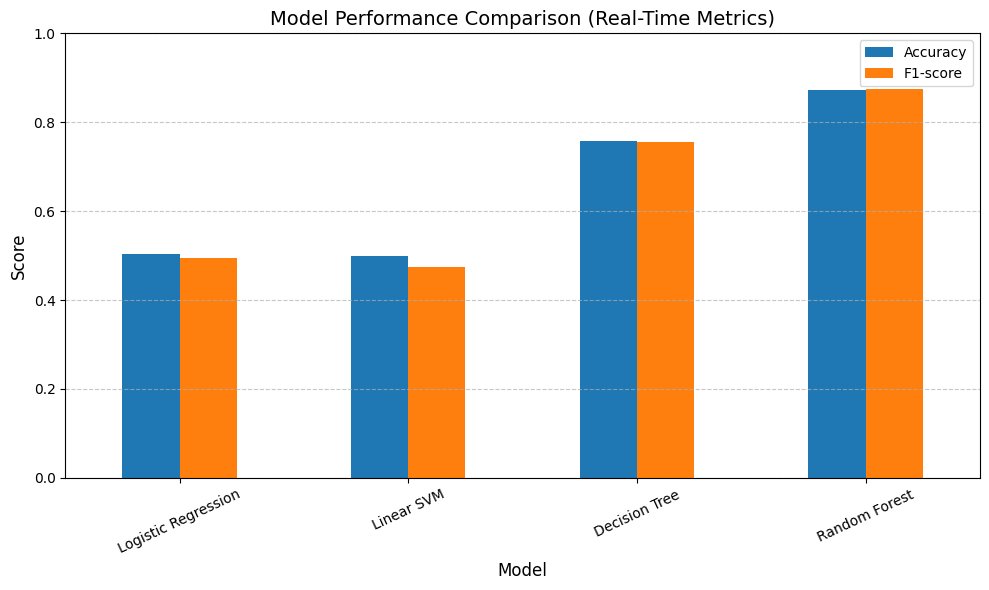

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

metrics_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Linear SVM",
        "Decision Tree",
        "Random Forest"
    ],
    "Accuracy": [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, svm_linear_pred),
        accuracy_score(y_test, dt_pred),
        accuracy_score(y_test, rf_pred)
    ],
    "F1-score": [
        f1_score(y_test, lr_pred, average="weighted"),
        f1_score(y_test, svm_linear_pred, average="weighted"),
        f1_score(y_test, dt_pred, average="weighted"),
        f1_score(y_test, rf_pred, average="weighted")
    ]
})

metrics_df.set_index("Model", inplace=True)

ax = metrics_df.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Model Performance Comparison (Real-Time Metrics)", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=25)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Confusion Matrix ( Error Analysis )

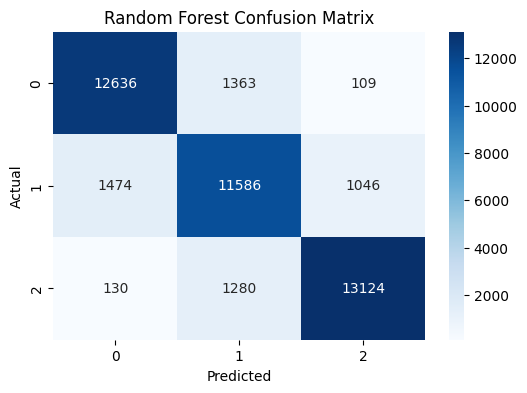

In [20]:
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion Matrix for other 3 models

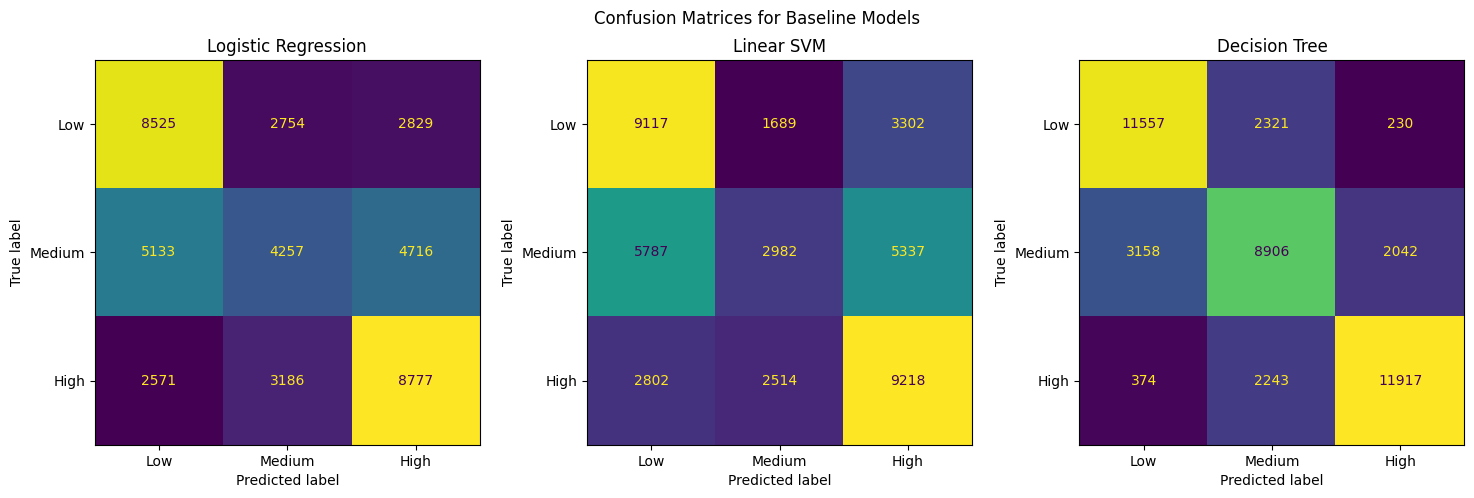

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": lr,
    "Linear SVM": svm_linear,
    "Decision Tree": dt
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_scaled if name != "Decision Tree" else X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Low", "Medium", "High"])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)

plt.suptitle("Confusion Matrices for Baseline Models")
plt.show()

Feature Importance

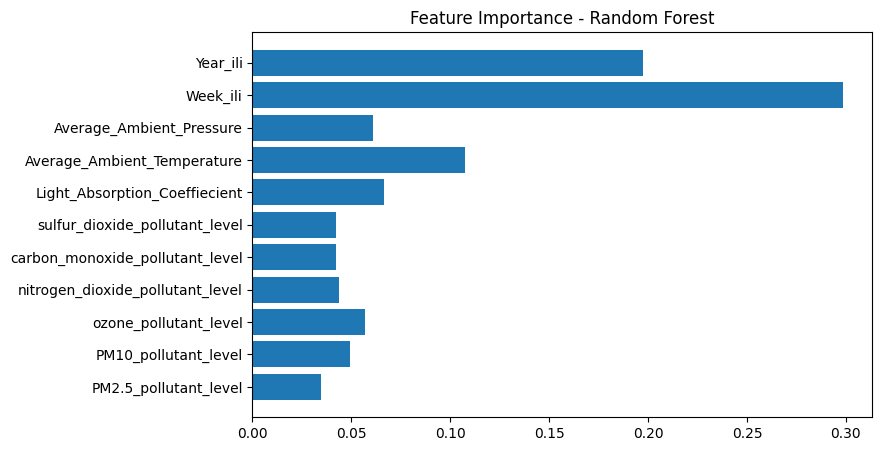

In [22]:
importances = rf.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Feature Importance - Random Forest")
plt.show()

| Model                     | Accuracy / F1 (approx.) | Interpretability | Training Time | Deployment Complexity | Role in Project                |
| ------------------------- | ----------------------- | ---------------- | ------------- | --------------------- | ------------------------------ |
| Baseline (Majority Class) | ~33%                    | Very High        | Negligible    | Very Low              | Reference baseline             |
| Logistic Regression       | ~50%                    | High             | Fast(6.8s)    | Very Low              | Linear baseline                |
| Linear SVM                | ~50%                    | Medium           | V.Fast (0.2s) | Low                   | Linear baseline                |
| Decision Tree             | ~75%                    | Very High        | Fast (0.4s)   | Low                   | Interpretable non-linear model |
| Random Forest             | ~87%                    | Medium           | Higher(17.7s) | Medium                | Final deployed model           |


The comparison highlights clear trade-offs between predictive performance, interpretability, and system complexity. Linear models such as Logistic Regression and Linear SVM offer fast training times and strong interpretability but achieve near-chance performance, indicating that respiratory illness risk is not linearly separable with respect to smog and environmental features. A Decision Tree significantly improves accuracy by capturing non-linear thresholds and interactions while remaining highly interpretable,however, its single tree structure leads to higher variance and reduced generalization. The Random Forest ensemble achieves the best overall performance by aggregating multiple decision trees, effectively modeling complex non-linear relationships between air pollution, weather conditions, and temporal factors. This performance gain comes at the cost of increased training time and reduced interpretability compared to simpler models. Consistent with real world machine learning deployment practices, the Random Forest model is selected for the final Proof of Concept system, while simpler models are retained for comparison and interpretability analysis during experimentation.

Save the Final model

In [23]:
import joblib

joblib.dump(rf, "rf_respiratory_risk.pkl")
joblib.dump(scaler, "scaler.pkl")  

['scaler.pkl']